In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#plt.style.use('dark_background')

import seaborn as sns
from scipy import stats
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


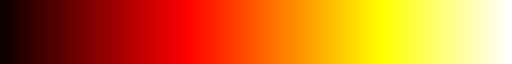

In [5]:
cm.hot

In [6]:
class Mixture2D:
    
    def __init__(self, K, x1_lim=[0, 2], x2_lim=[0, 3], alpha=10, sigma=1, border_factor=1):
        """
        
        Args:
            K: number of clusters
            x_lim, y_lim: upper and lower bound region
            alpha: dirichlet concentration parameter for component proportions
            sigma: observation variance
        """
        self.K = K
        self.x1_lim, self.x2_lim = x1_lim, x2_lim
        self.centers = np.random.uniform(size=[self.K, 2])
        border = sigma*border_factor
        self.centers[:, 0] = x1_lim[0] + border + (x1_lim[1]-x1_lim[0]-2*border)*self.centers[:, 0]
        self.centers[:, 1] = x2_lim[0] + border + (x2_lim[1]-x2_lim[0]-2*border)*self.centers[:, 1]
        self.props = np.random.dirichlet(alpha=alpha*np.ones([self.K]))
        self.sigma = sigma
        
    def sample(self, n_samples=1):
        center_idcs = np.random.choice(self.K, p=self.props, size=[n_samples])
        mus = self.centers[center_idcs]
        return mus + np.random.normal(loc=[0.,0.], scale=self.sigma, size=[n_samples, 2])
        
    def density(self, x):
        pdf = np.sum([
            prop_k*stats.norm.pdf(x, loc=mu_k, scale=self.sigma).prod(axis=-1)
            for mu_k, prop_k in zip(self.centers, self.props)
        ], axis=0)
        return pdf

In [7]:
K, alpha, sigma = 5, 1, 0.2
x1_lim, x2_lim = [0, 2], [0, 3]
mix = Mixture2D(K=K, x1_lim=x1_lim, x2_lim=x2_lim, alpha=alpha, sigma=sigma)

In [8]:
def density_grid(mix, grid_pts=100):
    x1_lim, x2_lim = mix.x1_lim, mix.x2_lim
    x1 = np.linspace(x1_lim[0], x1_lim[1], grid_pts)
    x2 = np.linspace(x2_lim[0], x2_lim[1], grid_pts)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.stack([X1, X2])
    X_vec = X.reshape([2, -1]).T
    Z_vec = mix.density(X_vec)
    Z = Z_vec.reshape([grid_pts, grid_pts])
    return X1, X2, Z

In [9]:

# Initialize plot
grid_pts = 100

def plot_mix_samples(mix, grid_pts=100, n_samples_plot=1000, seed=42):
    np.random.seed(seed)
    
    # Sample points and plot them
    x = mix.sample(n_samples=n_samples_plot)
    
    x1_lim, x2_lim = mix.x1_lim, mix.x2_lim
    
    joint_plot = sns.jointplot(
        x=x[:,0], y=x[:, 1],
        xlim=x1_lim, ylim=x2_lim,
        joint_kws={'color':'white', 's':6.},
    )
    
    # Sample points and plot them
    x_kde = mix.sample(n_samples=n_samples_plot*100)
    joint_plot.ax_marg_x.clear()
    sns.kdeplot(x_kde[:,0], color="white", bw_adjust=1., ax=joint_plot.ax_marg_x)
    joint_plot.ax_marg_y.clear()
    sns.kdeplot(y=x_kde[:,1], color="white", bw_adjust=1., ax=joint_plot.ax_marg_y)
    joint_plot.ax_marg_y.vlines(x=0, ymin=x2_lim[0], ymax=x2_lim[1])
    
    
    
    # Strip labels and ticks
    joint_plot.ax_joint.set_yticks([])
    joint_plot.ax_joint.set_xticks([])
    joint_plot.ax_marg_x.set_xticks([])
    joint_plot.ax_marg_x.set_yticks([])
    joint_plot.ax_marg_x.set_ylabel("")

    # To avoid that the scatter changes limits
    joint_plot.ax_joint.autoscale(False)
    return joint_plot
    
def plot_mix_density(ax, mix, grid_pts=100, n_samples_plot=1000, levels=None, z_clip=None):
    x1_lim, x2_lim = mix.x1_lim, mix.x2_lim

    # Compute density
    X1, X2, Z = density_grid(mix, grid_pts=grid_pts)
    if z_clip is not None:
        Z = np.clip(Z, a_min=0, a_max=z_clip)
    
    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.hot
    #levels = np.arange(0, Z.max(), Z.max()/5)
    if levels is None:
        levels = np.exp(-np.linspace(5, 0, 15)**2)*Z.max()

    # return contour set for mapping colorbar if desired
    CS = ax.contourf(X1, X2, Z, levels, cmap=cmap, zorder=0)
    return CS

def plot_motif_line(ax, mix, motif_y):
    x1_lim, x2_lim = mix.x1_lim, mix.x2_lim
    ax.hlines(y=motif_y, xmin=x1_lim[0], xmax=x1_lim[1], linestyle='--')

def plot_motif_density(ax, mix, motif_y, inflation_factor=1., grid_pts=grid_pts):
    # Choose location of "motif" in structure space
    x1_lim, x2_lim = mix.x1_lim, mix.x2_lim
    x1s = np.linspace(x1_lim[0], x1_lim[1], grid_pts)
    x2s = motif_y * np.ones_like(x1s) 
    xs = np.stack([x1s, x2s]).T
    motif_density = mix.density(xs)
    motif_density *= 1./((x1_lim[1] - x1_lim[0])*np.mean(motif_density))
    ax.plot(x1s, inflation_factor*motif_density, zorder=10, c='w', linestyle='--')
    

In [10]:
# Initialize mixture
K, alpha, sigma = 100, 0.15, 0.07
x1_lim, x2_lim = [0, 2], [0, 3]
seed = 48
np.random.seed(seed)
mix = Mixture2D(K=K, x1_lim=x1_lim, x2_lim=x2_lim, alpha=alpha, sigma=sigma)

n_samples_plot = 200


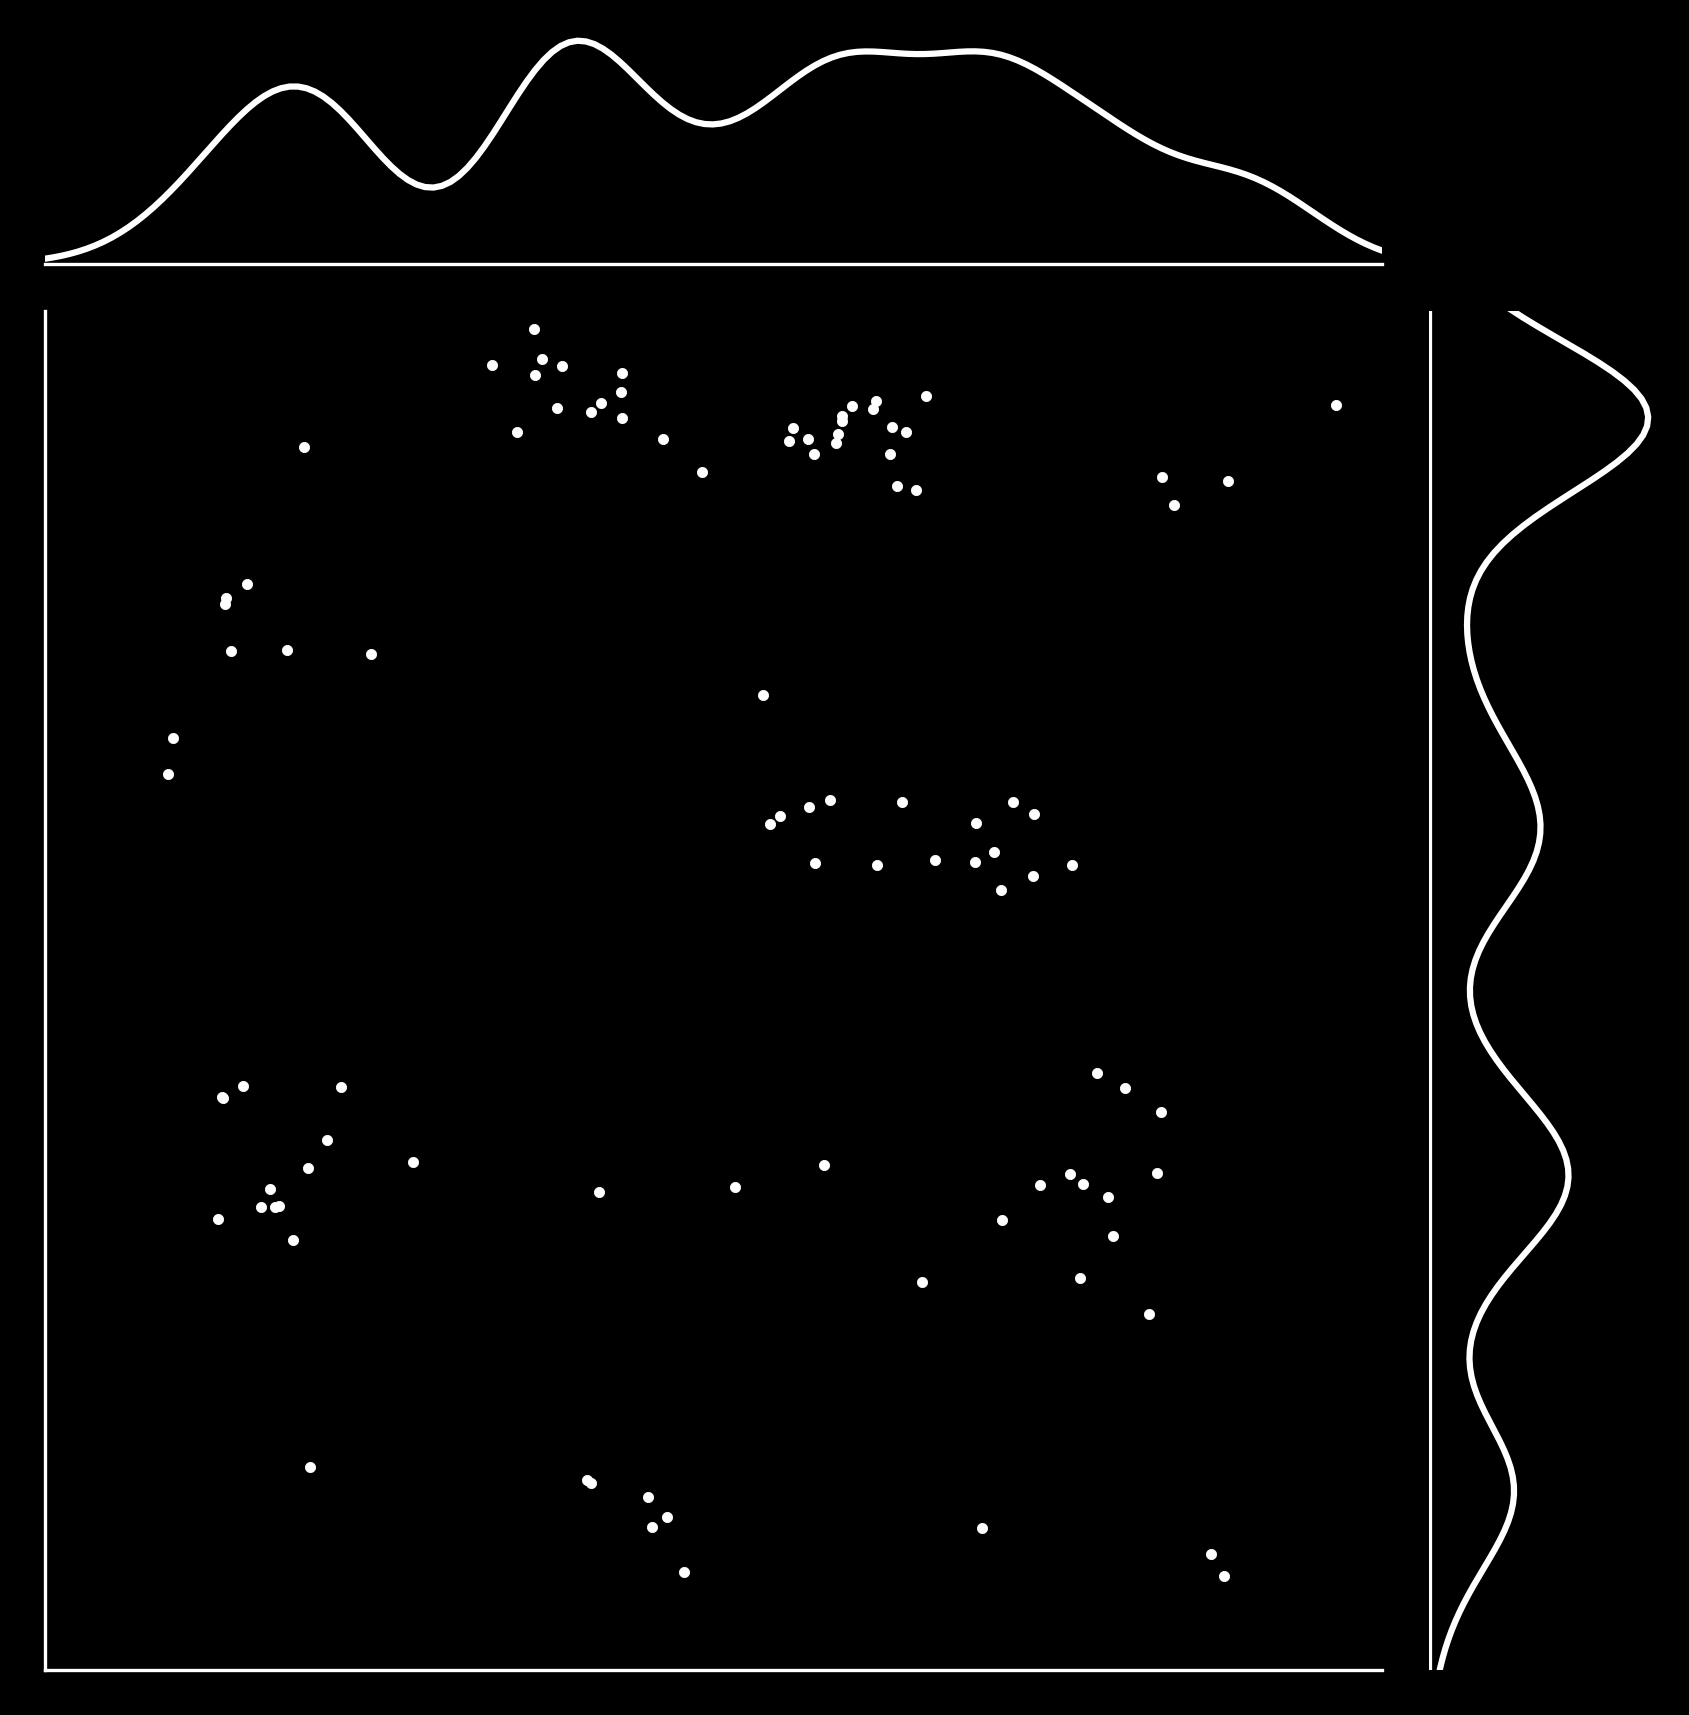

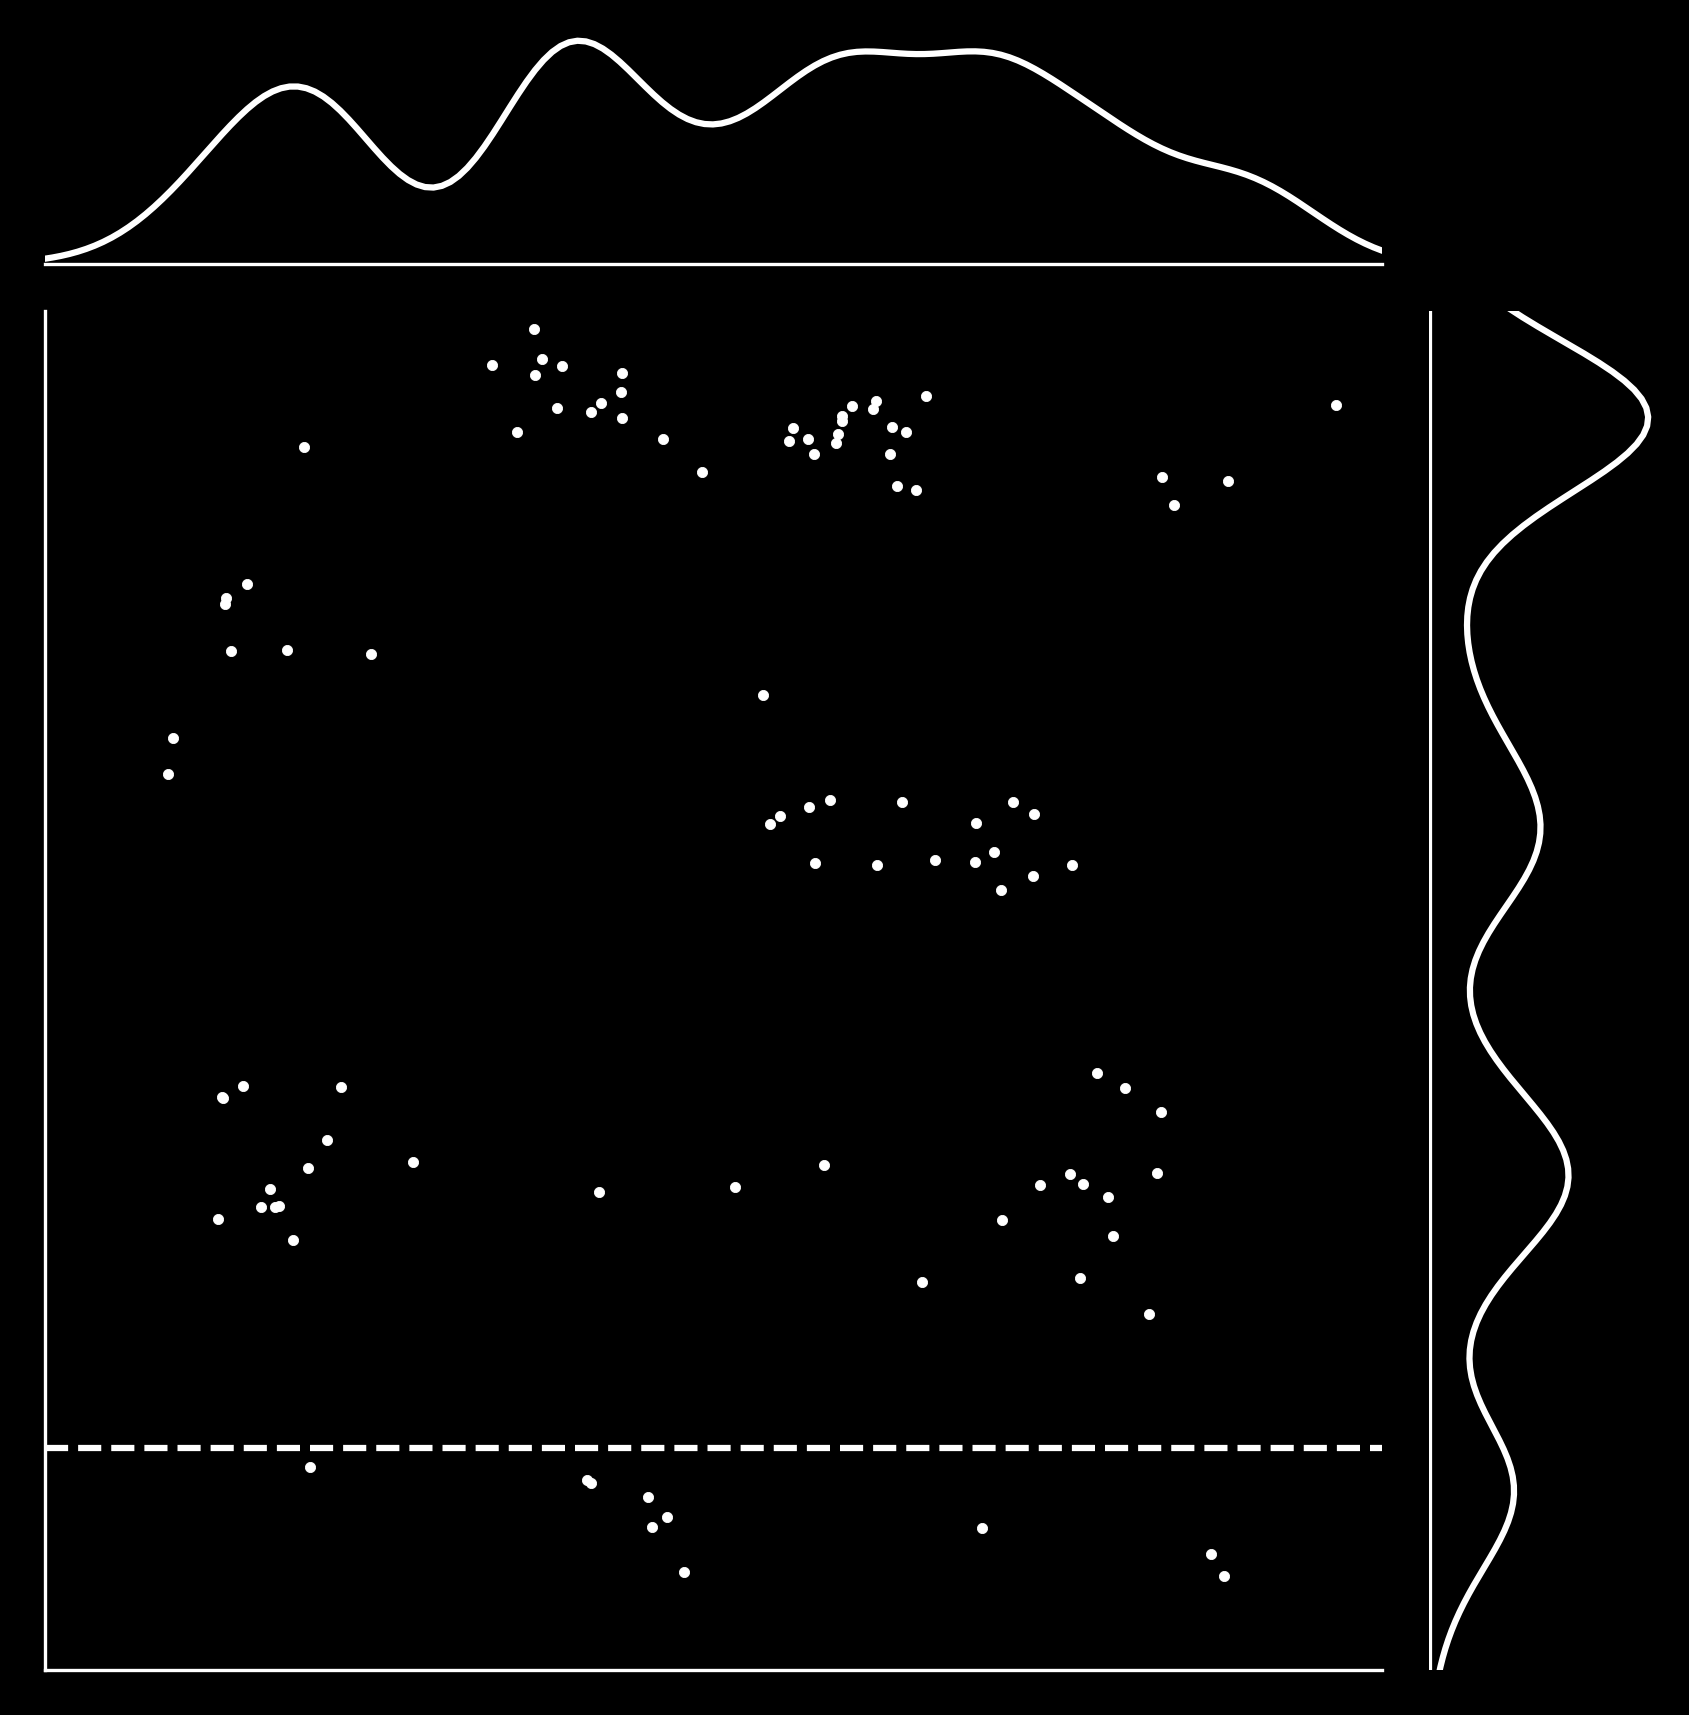

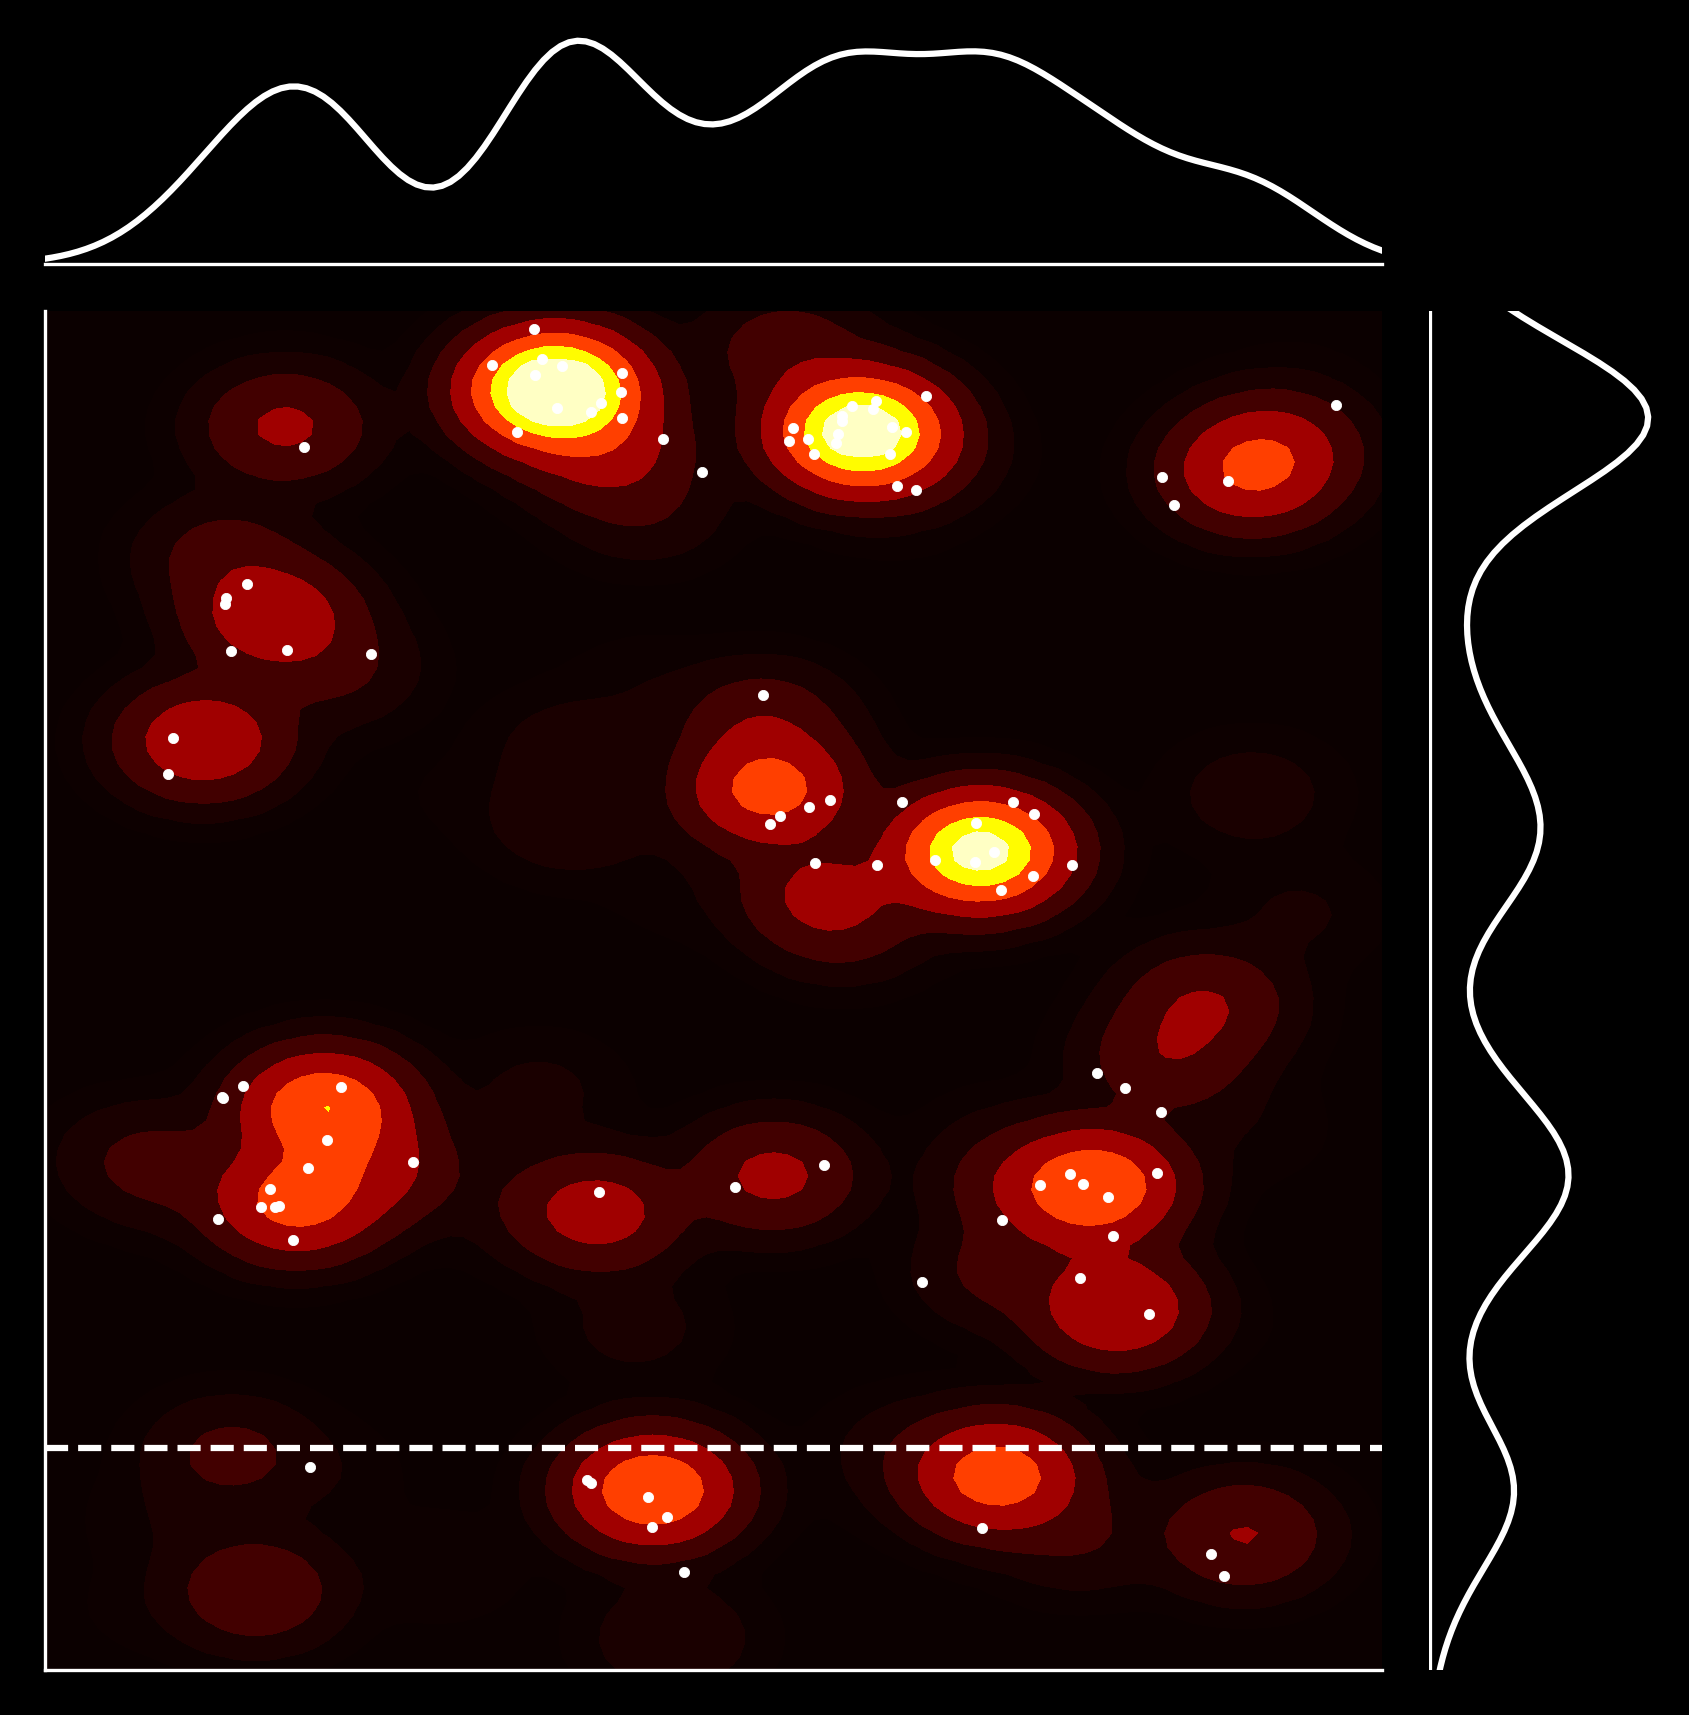

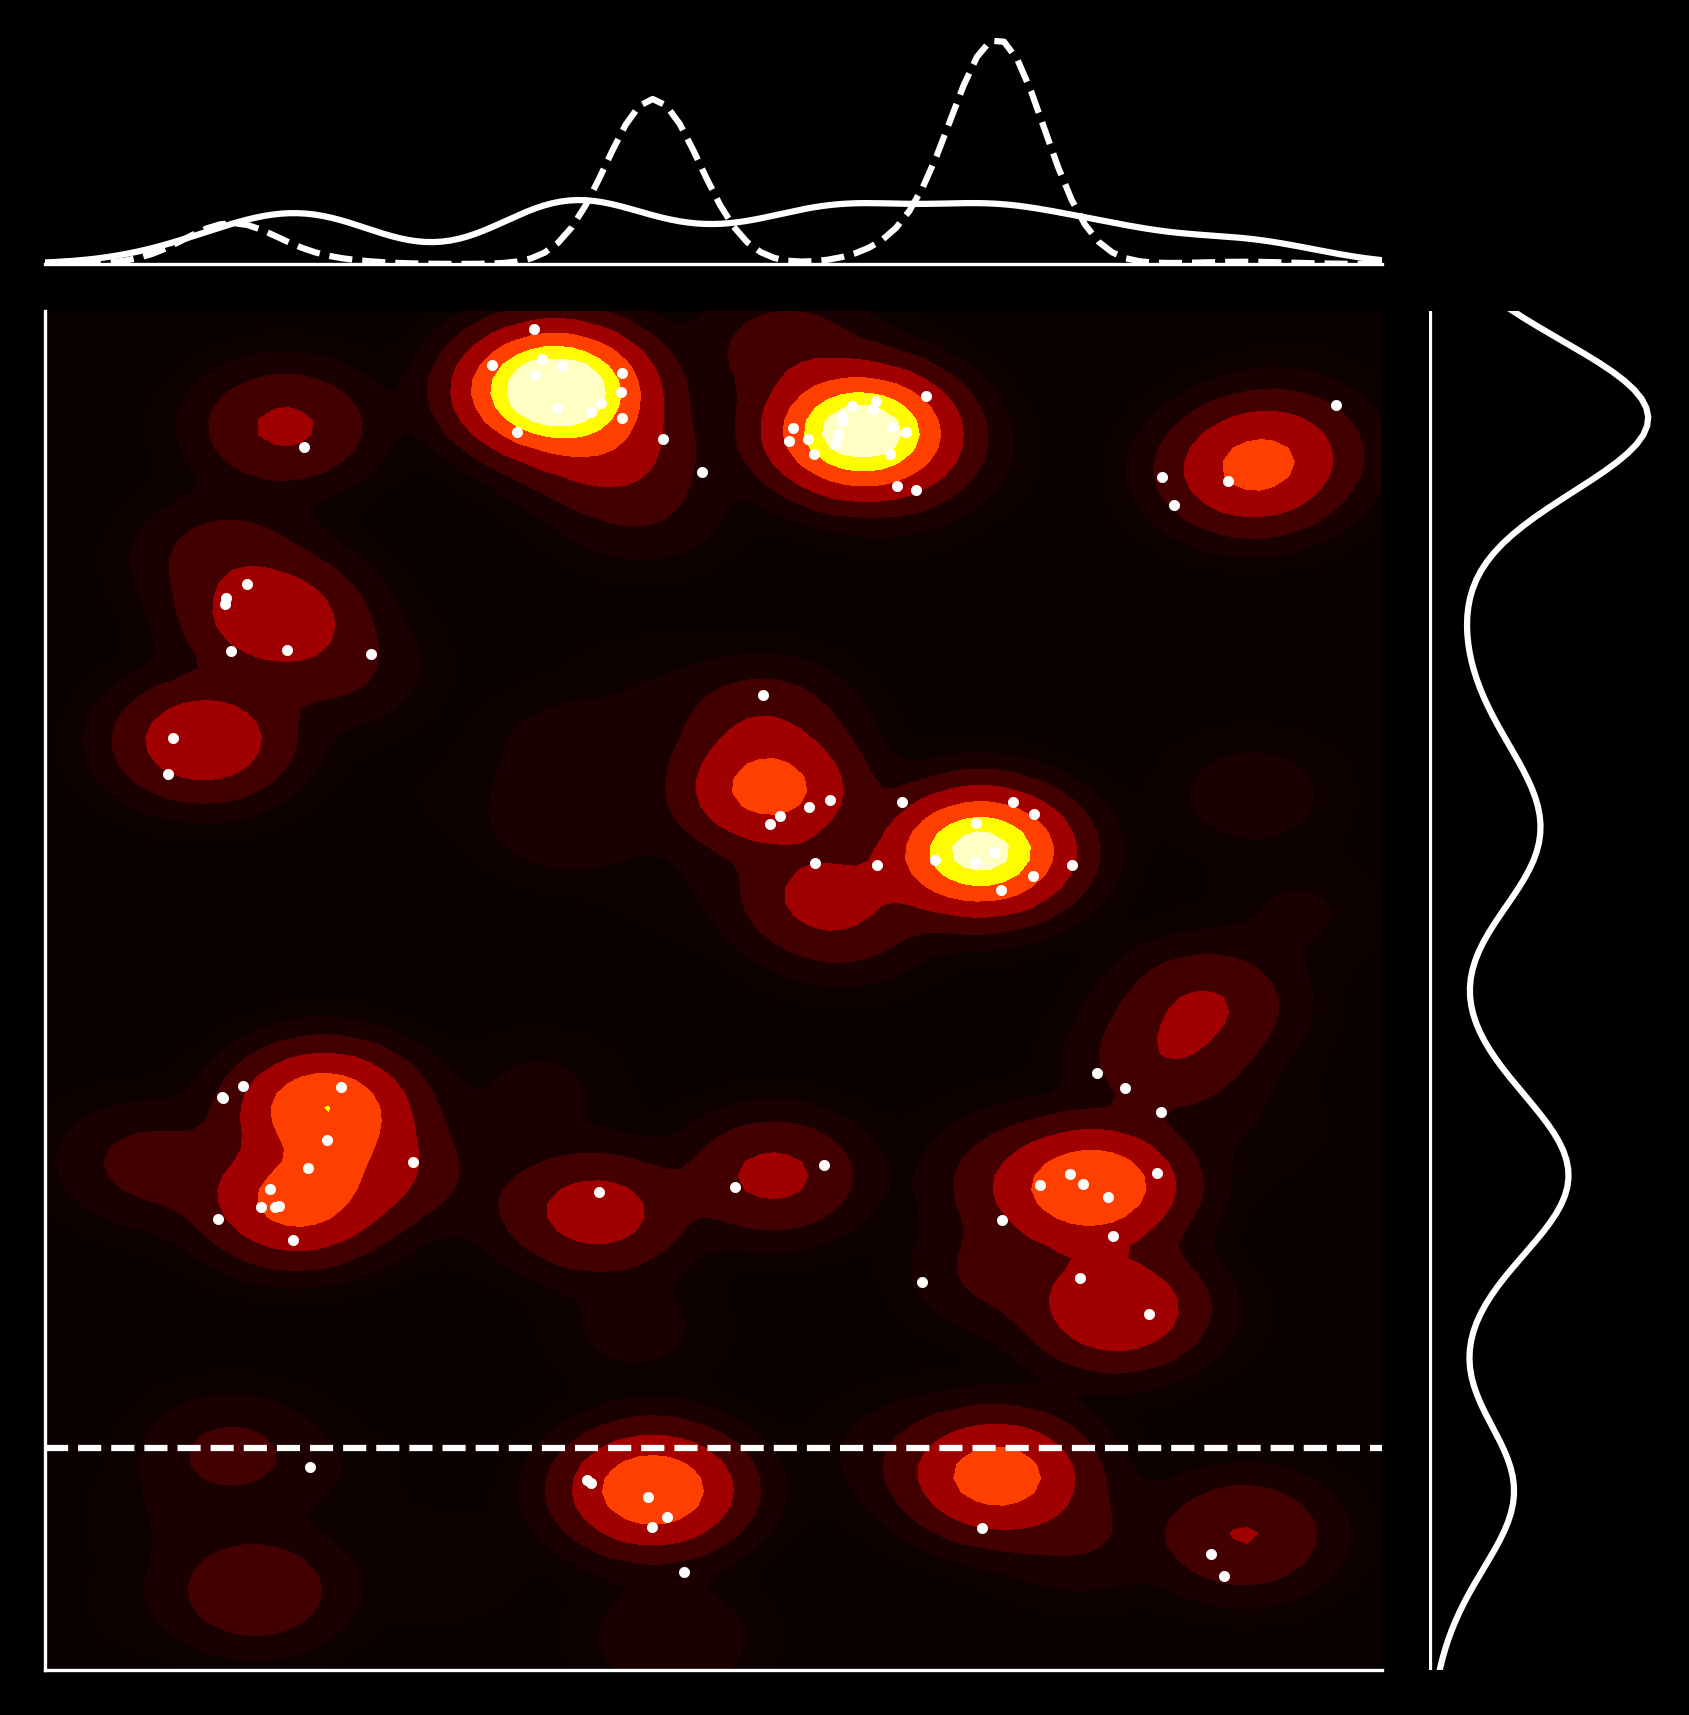

In [11]:
seed = 51
n_samples_plot =100
plt.style.use('dark_background')
# Just points
joint_plot = plot_mix_samples(mix, grid_pts=grid_pts, n_samples_plot=n_samples_plot, seed=seed)
joint_ax = joint_plot.ax_joint
plt.grid(False)
plt.axis('off')
plt.show()

# Points and motif
motif_y = 0.49
joint_plot = plot_mix_samples(mix, grid_pts=grid_pts, n_samples_plot=n_samples_plot, seed=seed)
joint_ax = joint_plot.ax_joint
plot_motif_line(joint_ax, mix, motif_y)
plt.grid(False)
plt.axis('off')
plt.show()


# Points, motif and contour
joint_plot = plot_mix_samples(mix, grid_pts=grid_pts, n_samples_plot=n_samples_plot, seed=seed)
joint_ax = joint_plot.ax_joint
plot_motif_line(joint_ax, mix, motif_y)
CS = plot_mix_density(joint_ax, mix, grid_pts=grid_pts, z_clip=3.)
#fig.colorbar(CS)
plt.grid(False)
plt.axis('off')
plt.show()


# Points, motif, density and motif conditional
joint_plot = plot_mix_samples(mix, grid_pts=grid_pts, n_samples_plot=n_samples_plot, seed=seed)
joint_ax = joint_plot.ax_joint
plot_motif_line(joint_ax, mix, motif_y)
CS = plot_mix_density(joint_ax, mix, grid_pts=grid_pts, z_clip=3.)
plot_motif_density(joint_plot.ax_marg_x, mix, motif_y, inflation_factor=1.)
#fig.colorbar(CS)
plt.grid(False)
plt.axis('off')
plt.show()


